In [1]:
import numpy as np
import pandas as pd
import datetime, pytz
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import os

### Load & Preprocess Data

In [2]:
start = datetime.datetime(2017, 6, 30, 0, 0, 0, 0, pytz.UTC)
end = datetime.datetime(2021, 1, 1, 0, 0, 0, 0, pytz.UTC)

#conversion function for the native timestamps in the csv file
def dateparse (time_in_secs):    
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))

#load the dataset 
data = pd.read_csv('./data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv', parse_dates=[0], date_parser=dateparse)
data = data[(data['Timestamp'] >= start) & (data['Timestamp'] <= end)]
data['Timestamp'] = data['Timestamp'].dt.tz_localize(None)
data = data.groupby([pd.Grouper(key='Timestamp', freq='H')]).first().reset_index()
data = data.set_index('Timestamp')
data = data[['Weighted_Price']]
data['Weighted_Price'].fillna(method='ffill', inplace=True)

data.head()

,Weighted_Price
Timestamp,
2017-06-30 00:00:00,2558.131179
2017-06-30 01:00:00,2547.053381
2017-06-30 02:00:00,2544.095732
2017-06-30 03:00:00,2554.179251
2017-06-30 04:00:00,2548.967498


In [3]:
# split data
split_date = '25-Jun-2019'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

In [8]:
# Data preprocess
training_set = data_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]

print(X_train.shape)

X_train = np.reshape(X_train, (len(X_train), 1, 1))

print(X_train.shape)
print(X_train[:5])

(17400, 1)
(17400, 1, 1)
[[[0.04071507]]

 [[0.04008955]]

 [[0.03992255]]

 [[0.04049192]]

 [[0.04019764]]]


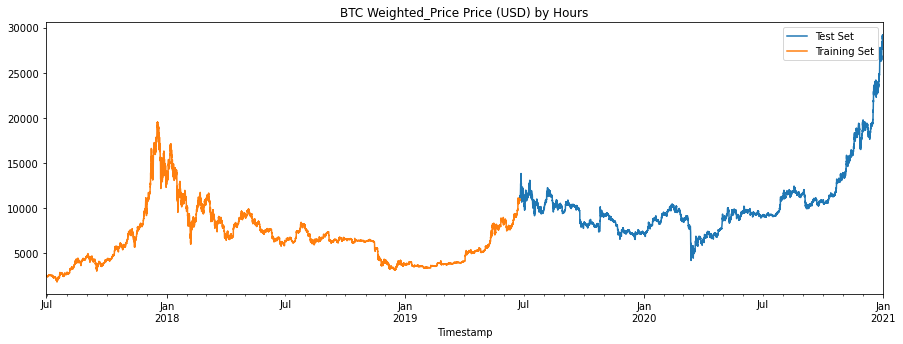

In [5]:
_ = data_test \
    .rename(columns={'Weighted_Price': 'Test Set'}) \
    .join(data_train.rename(columns={'Weighted_Price': 'Training Set'}), how='outer') \
    .plot(figsize=(15,5), title='BTC Weighted_Price Price (USD) by Hours', style='')

### Model architecture (LSTM)

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation


model = Sequential()
model.add(LSTM(128,activation="sigmoid", input_shape=(1,1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


### Training

In [7]:
checkpoint_path = "checkpoints/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1, 
                                                 save_freq=int(10 * (y_train.shape[0] / 50)))

model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=1, callbacks=[cp_callback])

Epoch 1/100
348/348 [==============================] - 1s 2ms/step - loss: 0.0539
Epoch 2/100
 66/348 [====>.........................] - ETA: 0s - loss: 0.0324

KeyboardInterrupt: 

### Predictions

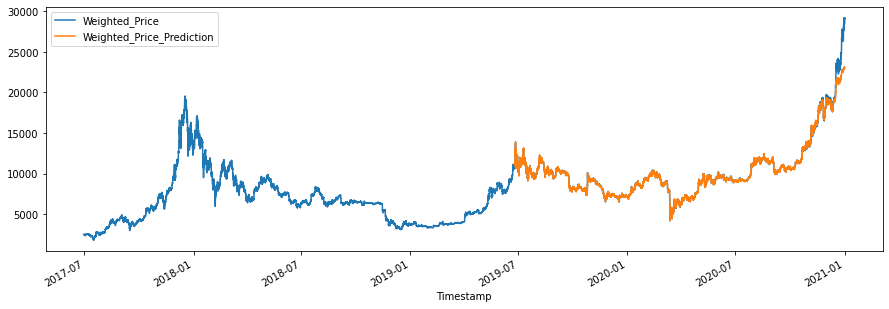

In [ ]:
test_set = data_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BTC_price = model.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)

data_test['Weighted_Price_Prediction'] = predicted_BTC_price
data_all = pd.concat([data_test, data_train], sort=False)

final_data = data_all
final_data = final_data.reset_index()
final_data = final_data.rename(columns={'Weighted_Price_Prediction': 'lstm'})
final_data = final_data[['Timestamp','Weighted_Price','lstm']]

_ = data_all[['Weighted_Price','Weighted_Price_Prediction']].plot(figsize=(15, 5))

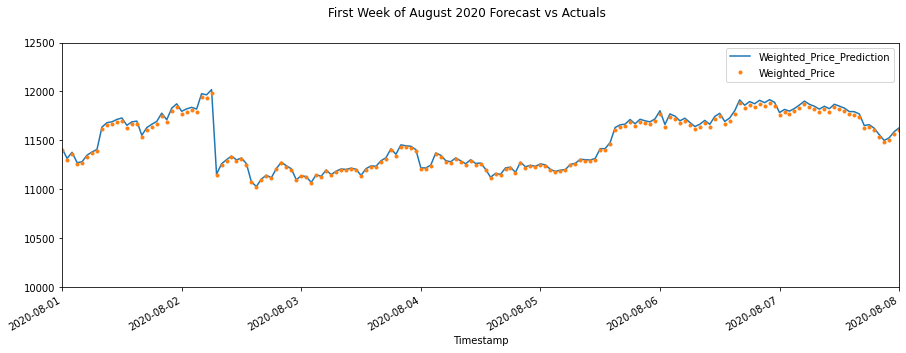

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Weighted_Price_Prediction','Weighted_Price']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='08-01-2020', upper='08-08-2020')
ax.set_ylim(10000, 12500)
plot = plt.suptitle('First Week of August 2020 Forecast vs Actuals')

### Performance Evaluation

In [ ]:
#calculate MSE and MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_squared_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Weighted_Price_Prediction'])

284271.03442112275

In [ ]:
mean_absolute_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Weighted_Price_Prediction'])

107.50316109968338